In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots

import pandas as pd
import xarray as xr
import seaborn as sns
import warnings

import logging

from skimage import measure 
from scipy.optimize import minimize
import plotly.graph_objects as go
from shapely.geometry import LineString
import matplotlib.patheffects as path_effects
from matplotlib.patches import Polygon as MplPolygon

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

In [2]:
alpha = "25" #compare to article this is 100(1-alpha) 
nbpd = 20 # maybe trying with 40 once the legends are added
nd = 4
same_rank_bool = True # if False then the jdist ranks are computed for ocean and land, rather than for both

fig_path = f"/scratchx/mcarenso/tempest/figures/threshold_and_sigmas_nd_{nd}_nbpd_{nbpd}_alpha_{alpha}_same_rank_{str(same_rank_bool)}.png"

In [3]:

def plot_kite(jd, fig=None, ax=None):
    if fig is None : 
        fig, ax = plt.subplots(1, 1)
    # Plot the initial polygons

    _, curve1, curve2 = find_plot_contour(jd, ax_show = False, N_branch=81, offset_low = 1, offset_up=1, color = 'k', lstyle="--", model_name = model_name+" Summer")

    curve1_coords = np.array(curve1.coords)

    km90_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,1]-20))
    last_index = np.argmin(np.abs(curve1_coords[:,1]-40))
    km90_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    km90_vertices.append((40, 40))  
    km90_vertices.append((20, 20))  

    km99_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,1]-40))
    last_index = np.argmin(np.abs(curve1_coords[:,1]-81))
    km99_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    km99_vertices.append((81, 81))  
    km99_vertices.append((40, 40))  

    curve1_coords = np.array(curve2.coords)

    dd90_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,0]-20))
    last_index = np.argmin(np.abs(curve1_coords[:,0]-40))
    dd90_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    dd90_vertices.append((40, 40))  
    dd90_vertices.append((20, 20))  

    dd99_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,0]-40))
    last_index = np.argmin(np.abs(curve1_coords[:,0]-81))
    dd99_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    dd99_vertices.append((81, 81))  
    dd99_vertices.append((40, 40))  

    polygons = [
        (km90_vertices, 'green', '90th \n km '),
        (km99_vertices, 'lime', '99th \n km '),
        (dd99_vertices, 'cyan', '99th \n dd '),
        (dd90_vertices, 'blue', '90th \n dd ')
    ]

    # Create a new patch with the constructed vertices
    for vertices, color, label in polygons:
                                                #reviewer doesn't like color so ciao facecolor=color
        polygon = MplPolygon(vertices, closed=True, edgecolor=color, facecolor="none", linewidth=3, linestyle='--', alpha=0.8) 
        ax.add_patch(polygon)
        
        # Calculate approximate center for text placement
        x_coords, y_coords = zip(*vertices)
        center_x = np.mean(x_coords) if "dd" in label else np.mean(x_coords)-8
        center_y = np.mean(y_coords) if "km" in label else np.mean(y_coords)-8
        
        # Add text annotation
        text = ax.text(center_x, center_y, label, color=color, fontsize=12, ha='center', va='center', weight='bold')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])
    
    return None


def find_plot_contour(self, ax_show , N_branch=80, offset_low = 1, offset_up=1, color = 'k', lstyle = '--', model_name = None):
    Z = self.norm_density.T
    # -- Branches
    Z_contour = np.copy(Z)
    # Z_contour[18:, 18:] = 1 ## this number actually depends on nd and nbpd and the general shape of the Y 
    cont = measure.find_contours(Z_contour, 1)
    N = N_branch

    # print(len(cont))
    # for i, c in enumerate(cont):
    #     print(i, c.shape)
    # fit
    popt_1, x_1, y_1, popt_2, x_2, y_2, func = self._fit_branches(cont,N, offset_low, offset_up)
    x_branch_2 = y_branch_1 = np.linspace(5,N_branch,N_branch)
    y_branch_2 = func(x_branch_2,*popt_2)
    x_branch_1 = func(y_branch_1,*popt_1)

    # Create line strings for intersection
    curve1 = LineString(np.column_stack((x_branch_1, y_branch_1)))
    curve2 = LineString(np.column_stack((x_branch_2, y_branch_2)))
    
    if ax_show is not False : 
        # show branches
        ax_show.plot(x_branch_1,y_branch_1, color = color, linestyle = lstyle, linewidth = 3, alpha = 0.5)
        ax_show.plot(x_branch_2,y_branch_2, color = color, linestyle = lstyle, linewidth = 3, alpha = 0.5, label  = model_name)

    return ax_show, curve1, curve2



In [4]:
##Preshow 
settings_path = 'settings/obs_winter_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(cs, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd_winter = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec", nbpd = 20,  nd=4, overwrite = True, dist_mask = "all")

settings_path = 'settings/obs_summer_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(cs, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd_summer = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec", nbpd = 20,  nd=4, overwrite = True, dist_mask = "all")

Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Data loaded from /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


(613, 2)
Fitting 1st branch
1st branch successfully fitted
Fitting 2nd branch
2nd branch successfully fitted
(613, 2)
Fitting 1st branch
1st branch successfully fitted
Fitting 2nd branch
2nd branch successfully fitted


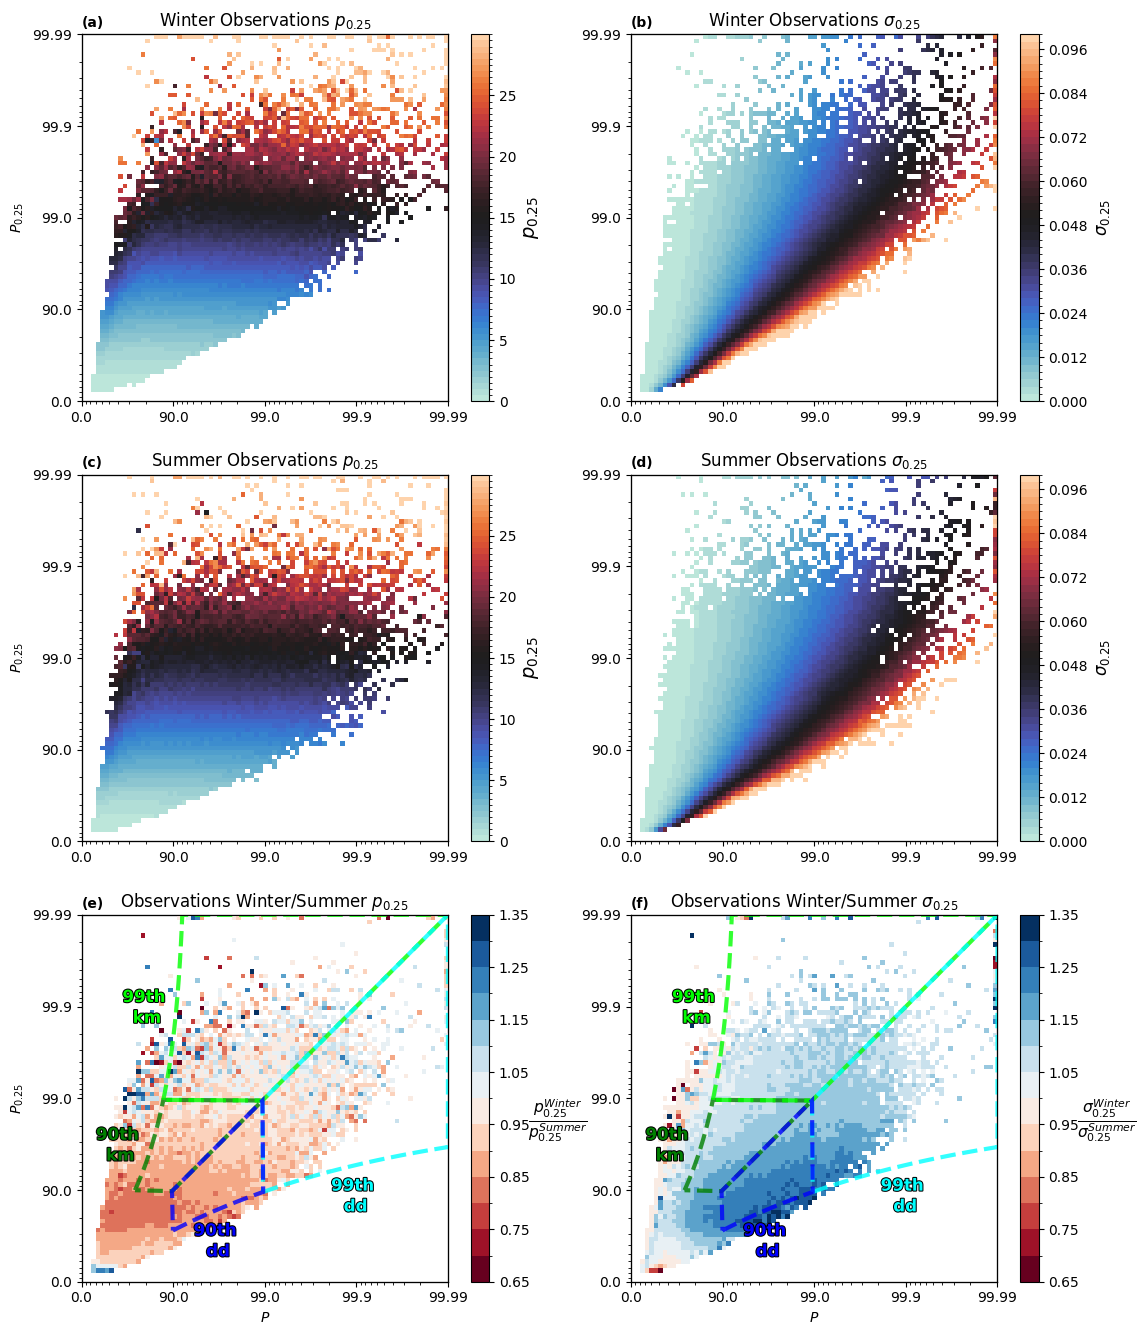

In [11]:
# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(13, 16.2))

## THRESHOLDS 
model_name = jd_winter.settings["MODEL"][:-7]
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 30.5, 0.5)
values = values_and_boundaries
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

## THRESHOLD WINTER
ax, cb, ax_show_, threshold_density_obs_winter = jd_winter.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axes[0,0])
axes[0,0].set_ylabel(r"$P_{0.25}$")
axes[0,0].set_xlabel(r" ")
cb.set_label(r"$p_{0.25}$", fontsize=14)
cb.set_ticks(np.arange(0, 30, 5))
axes[0,0].set_title("Winter Observations " + r"$p_{0.25}$") #+ "\n" + "threshold " 
axes[0,0].text(-0., 1.05, "(a)", transform=axes[0,0].transAxes, fontweight='bold', va='top')

## THRESHOLD SUMMER
ax, cb, ax_show_, threshold_density_obs_summer = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axes[1,0])
axes[1,0].set_ylabel(r"$P_{0.25}$")
axes[1,0].set_xlabel(r" ") #$P$
cb.set_label(r"$p_{0.25}$", fontsize=14)
cb.set_ticks(np.arange(0, 30, 5))
axes[1,0].set_title("Summer Observations " + r"$p_{0.25}$") #+ "\n" + "threshold "
axes[1,0].text(-0., 1.05, "(c)", transform=axes[1,0].transAxes, fontweight='bold', va='top')


## THRESHOLD RATIO 
cmap = sns.color_palette("RdBu", as_cmap=True)
values_and_boundaries = np.arange(0.65, 1.40, 0.05) #
values = values_and_boundaries
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

obs_season_ratio_threshold_75 = threshold_density_obs_winter/threshold_density_obs_summer
ax, cb, ax_show, _ = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axes[2,0], density=obs_season_ratio_threshold_75)
axes[2,0].set_ylabel(r"$P_{0.25}$")
axes[2,0].set_xlabel(r"$P$")
cb.ax.set_ylabel(r'$\frac{p^{Winter}_{0.25}}{p^{Summer}_{0.25}}$', fontsize=16, rotation = 0, labelpad = 20)

title = r"Observations Winter/Summer "+ r"$p_{0.25}$" #+"\n"+ "ratio of threshold " 
axes[2,0].set_title(title)
plot_kite(jd_summer, fig, ax_show)
axes[2,0].text(-0., 1.05, "(e)", transform=axes[2,0].transAxes, fontweight='bold', va='top')

## SIGMAS
model_name = jd_winter.settings["MODEL"][:-7]
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.1+0.002, 0.002)
values = values_and_boundaries
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

## SIGMA WINTER
ax, cb, ax_show, sigma_density_obs_winter = jd_winter.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axes[0,1])
axes[0,1].set_ylabel(r" ") #$P_{0.25}$
axes[0,1].set_xlabel(r" ") #$P$
cb.set_label(r"$\sigma_{0.25}$", fontsize=12)
axes[0,1].set_title(r"Winter Observations " +r"$\sigma_{0.25}$")
axes[0,1].text(-0., 1.05, "(b)", transform=axes[0,1].transAxes, fontweight='bold', va='top')

## SIGMA SUMMER
ax, cb, ax_show, sigma_density_obs_summer = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axes[1,1])
axes[1,1].set_ylabel(r" ") #$P_{0.25}$
axes[1,1].set_xlabel(r" ") #$P$
cb.set_label(r"$\sigma_{0.25}$", fontsize=12)
axes[1,1].set_title(r"Summer Observations " + r"$\sigma_{0.25}$")
axes[1,1].text(-0., 1.05, "(d)", transform=axes[1,1].transAxes, fontweight='bold', va='top')

## SIGMA RATIO
cmap = sns.color_palette("RdBu", as_cmap=True)
values_and_boundaries = np.arange(0.65, 1.40, 0.05) #
values = values_and_boundaries
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

obs_season_ratio_sigma_75 = sigma_density_obs_winter/sigma_density_obs_summer
ax, cb, ax_show, _ = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axes[2,1], density=obs_season_ratio_sigma_75)
axes[2,1].set_ylabel(r" ") #$P_{0.25}$
axes[2,1].set_xlabel(r"$P$")
cb.ax.set_ylabel(r'$\frac{\sigma^{Winter}_{0.25}}{\sigma^{Summer}_{0.25}}$', fontsize=16, rotation = 0, labelpad = 20)

title = r"Observations Winter/Summer "+r"$\sigma_{0.25}$"
axes[2,1].set_title(title)
plot_kite(jd_summer, fig, ax_show)
axes[2,1].text(-0., 1.05, "(f)", transform=axes[2,1].transAxes, fontweight='bold', va='top')

# SHOW THE PLOT 
plt.savefig(fig_path, dpi = 300)
plt.show()